In [1]:
!pip install -q opendatasets

# 🔵 **Imports**

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import opendatasets as od
from PIL import Image
import os
import random

# 🔵 **Utils**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔵 **Dataset**

## 🔵 **LoadDataset**

In [6]:
url = "https://www.kaggle.com/datasets/splcher/animefacedataset"
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:19<00:00, 21.6MB/s]


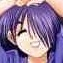

In [7]:
Image.open("/content/animefacedataset/images/0_2000.jpg")

In [8]:
images_list = os.listdir("/content/animefacedataset/images/")

In [9]:
len(images_list)

63565

## 🔵 **CustomDataset**

In [10]:
size = 64
norm_params = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_transform = T.Compose([T.Resize(size = (size, size)),
                             T.ToTensor(),
                             T.Normalize(*norm_params)])

In [11]:
class AnimeFace(Dataset):
  def __init__(self, root, images_name, transform):
    self.root = root
    self.images_name = images_name
    self.transform = transform
    self.norm_params = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

  def __getitem__(self, index):
    image = Image.open(self.root + '/' + self.images_name[index]).convert("RGB")

    if self.transform:
      image_tensor = self.transform(image)

    else:
      image_tensor = T.Compose([T.Resize(size = (size, size)),
                             T.ToTensor(),
                             T.Normalize(*self.norm_params)])(image)

    return image_tensor

  def __len__(self):
    return len(self.images_name)

In [12]:
root_dir = "/content/animefacedataset/images"
train_dataset = AnimeFace(root_dir, images_list, train_transform)

In [13]:
len(train_dataset)

63565

In [14]:
train_dataset[0].shape

torch.Size([3, 64, 64])

## 🔵 **Visualize**

In [15]:
def visualize_random_data(dataset, n):
  n_list = random.sample(range(0, len(dataset)), n)
  images_list = []
  norm_p = dataset.norm_params
  norm_p = torch.tensor(norm_p[0]).unsqueeze(1).unsqueeze(2), \
           torch.tensor(norm_p[1]).unsqueeze(1).unsqueeze(2)

  for item in n_list:
    images_list.append(dataset[item]*norm_p[1]+norm_p[0])

  fig, ax = plt.subplots(figsize = (8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(torch.cat([img.unsqueeze(0) for img in images_list], dim = 0), nrow = 8).permute(1, 2, 0))


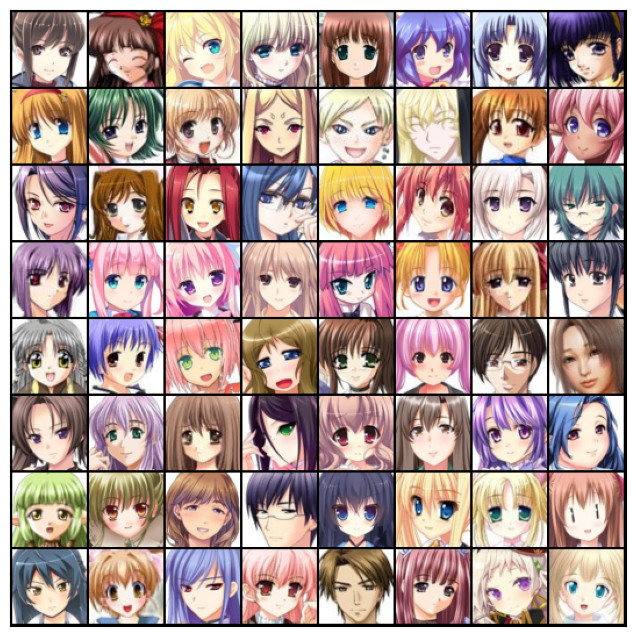

In [16]:
visualize_random_data(train_dataset, 64)

## 🔵 **DataLoaders**

In [17]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=2)

In [18]:
next(iter(train_loader)).shape

torch.Size([32, 3, 64, 64])

# 🔵 **Model**

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

  def forward(self, image):
    return self.net(image)

In [20]:
Discriminator()(torch.rand(2, 3, 64, 64)).shape

torch.Size([2, 1])

In [21]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

  def forward(self, input):
    return self.net(input)

In [22]:
Generator()(torch.rand(2, 128, 1, 1)).shape

torch.Size([2, 3, 64, 64])

# 🔵 **Train**

In [23]:
def train_discriminiator(D_model, G_model, input, loss_func, optimizer_D, device):
  D_model.zero_grad()

  x = input.to(device)
  bs, ch, h, w = x.shape

  y_real = torch.ones(bs, 1).to(device)
  z = torch.randn(bs, 128, 1, 1).to(device)
  y_fake = torch.zeros(bs, 1).to(device)

  out_D = D_model(x)
  loss_D_real = loss_func(out_D, y_real)

  out_G = G_model(z)
  out_D = D_model(out_G)
  loss_D_fake = loss_func(out_D, y_fake)

  loss_total_D = loss_D_fake + loss_D_real

  loss_total_D.backward()
  optimizer_D.step()

  return loss_total_D

def train_generator(G_model, D_model, loss_func, optimizer_G, bs, device):
  G_model.zero_grad()
  z = torch.randn(bs, 128, 1, 1).to(device)
  y_fake = torch.ones(bs, 1).to(device)
  out_G = G_model(z)
  out_D = D_model(out_G)
  loss_G_real = loss_func(out_D, y_fake)

  loss_G_real.backward()
  optimizer_G.step()

  return loss_G_real

In [24]:
def train_one_epoch(D_model, G_model, N_D, N_G, train_loader, loss_func, optimizer_G, optimizer_D, device, epoch):
  loss_G = AverageMeter()
  loss_D = AverageMeter()

  with tqdm(train_loader, unit = 'batch') as tepoch:
    for x in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch = {epoch + 1:03d}')

        bs = x.shape[0]
        for i in range(N_D):
          loss_total_D = train_discriminiator(D_model, G_model, x, loss_func, optimizer_D, device)
          loss_D.update(loss_total_D)
        for i in range(N_G):
          loss_total_G = train_generator(G_model, D_model, loss_func, optimizer_G, bs, device)
          loss_G.update(loss_total_G)


        tepoch.set_postfix(Dis_loss = loss_D.avg.item(), Gen_loss = loss_G.avg.item())

  return loss_D.avg.item(), loss_G.avg.item()



# 🔵 **Training Process**

In [ ]:
torch.cuda.empty_cache()

In [25]:
model_D = Discriminator().to(device)
model_G = Generator().to(device)
num_trainable_params(model_D), num_trainable_params(model_G)

(2.765696, 3.80608)

In [26]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers=2)

In [27]:
loss_D_hist, loss_G_hist = [], []

In [28]:
optimizer_D = optim.Adam(model_D.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(model_G.parameters(), lr = 0.0002, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

In [30]:
for epoch in range(47, 50):
  loss_D, loss_G = train_one_epoch(D_model=model_D,\
                                   G_model=model_G,\
                                   N_D = 1,\
                                   N_G = 2, \
                                   train_loader=train_loader,\
                                   loss_func=loss_function,\
                                   optimizer_G=optimizer_G,\
                                   optimizer_D=optimizer_D,\
                                   device=device,\
                                   epoch=epoch)

  bs, ch, h, w = next(iter(train_loader)).shape
  z = torch.randn(64, 128, 1, 1).to(device)
  out = model_G(z)
  save_image(out, f'/content/gan-{epoch:03d}.png')

  loss_D_hist.append(loss_D)
  loss_G_hist.append(loss_G)

Epoch = 050: 100%|██████████| 497/497 [03:11<00:00,  2.60batch/s, Dis_loss=0.136, Gen_loss=4.73]


In [31]:
torch.save(model_D, "D.pth")
torch.save(model_G, "G.pth")

## 🔵 **Plot**

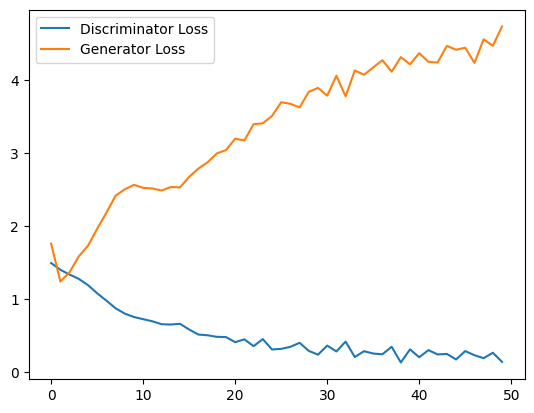

In [32]:
plt.plot(range(0, len(loss_D_hist)), loss_D_hist, label = "Discriminator Loss")
plt.plot(range(0, len(loss_G_hist)), loss_G_hist, label = "Generator Loss")
plt.legend()
plt.show()

# 🔵 **Create Video From Pictures**

In [49]:
import os
images = os.listdir("/content/")
images = images[1:9]+images[10:15]+images[16:21]+images[22:-5]+images[-4:-1]
len(images)

50

In [56]:
images.sort()

In [57]:
images[0]

'gan-000.png'

In [66]:
import cv2
import numpy as np
import glob

img_array = []
for filename in images:
   img = cv2.imread(filename)
   height, width, layers = img.shape
   size = (width,height)
   img_array.append(img)

In [68]:
out = cv2.VideoWriter('video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)

for i in range(len(img_array)):
   out.write(img_array[i])
out.release()